In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
%matplotlib inline
import seaborn as sns
%pylab inline
#pylab.rcParams['figure.figsize'] = (12, 12)

Populating the interactive namespace from numpy and matplotlib


## Experimental Setups
1. AWS EC2 instances: p2.xlarge
2. Model: ResNet-50
3. Dataset: ImageNet
4. Global batch size: 256
5. Scales of cluster: 2, 4, 8, 16, 32
6. Codebase: `DistributedDataParallel` in PyTorch

## Prelimaries & Assumptions
1. In `DistributedDataParallel`, Computations and Communications are overlapped
2. Global batch size $B$ are fixed when varying cluster size. A global is splitted evenly across workers, each worker computes $\frac{B}{P}$ gradients.

In [2]:
# local batch sizes: 128, 64, 32, 16, 8
runtime_scales = np.array([2.524942111968994, 1.3544952869415283, 1.1145174503326416, 1.2169253826141357, 1.2800402641296387]) * 1000.0

# associated computation time on p2 instances
comp_times = np.array([2310.995361328125, 1188.7835083007812, 624.0544891357422, 321.1659851074219, 186.42646026611328])

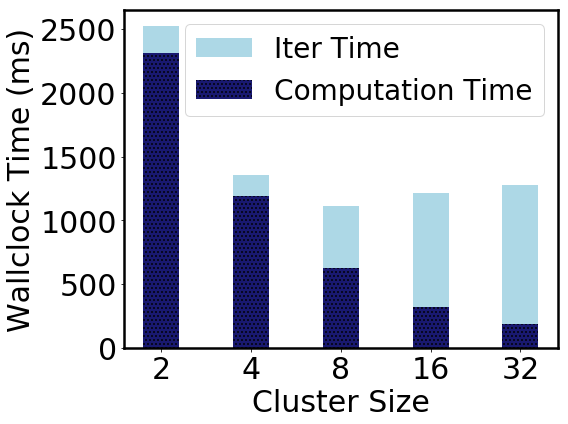

In [16]:
from matplotlib import colors as mcolors
from pylab import *

#fig = plt.figure(figsize=(15, 15))
#fig = plt.figure(figsize=(6, 4))

colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

# Sort colors by hue, saturation, value and name.
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])), name)
                for name, color in colors.items())
rc('axes', linewidth=2.5)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

N = 5
# comp cost, comm cost, decoding cost
#comp_costs.append(_tmp_comp_costs)
#comm_costs.append(_tmp_comm_costs)
#decode_costs.append(_tmp_decode_costs)
def take_avg(l):
    return sum(l) / float(len(l))

#draco_lite = [take_avg(comp_costs[0]), take_avg(comm_costs[0]), take_avg(decode_costs[0])]
#draco = [take_avg(comp_costs[1]), take_avg(comm_costs[1]), take_avg(decode_costs[1])]

ind = np.arange(N)  # the x locations for the groups
width = 0.4      # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
# Total Time
rects1 = ax.bar(ind+width/2, runtime_scales, width, color=colors['lightblue'], label="Iter Time")
# Comp Time
rects2 = ax.bar(ind+width/2, comp_times, width, color=colors['midnightblue'], label="Computation Time", hatch='...')

# add some text for labels, title and axes ticks
ax.set_ylabel("Wallclock Time (ms)",fontsize=30)
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('2', '4', '8', '16', '32'))
ax.set_xlabel("Cluster Size",fontsize=30)
#ax.legend()

#ax.set_ylim(0, 500)
plt.xticks(size=30)
plt.yticks(size=30)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0),size=20)

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

legend_properties = {'size':28}
#ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
#           ncol=1, mode="expand", borderaxespad=0., prop=legend_properties)
ax.legend(prop=legend_properties)

plt.tight_layout()
plt.savefig("ring_reduce_time.pdf", format='pdf', dpi=600, bbox_inches='tight', pad_inches=0.05)

## Observation from the previous plot
1. Communication overheads appears only when communication costs can't be well overlapped with computation costs.
3. Based on the theory, the total communication time is $\beta \times \frac{2(P-1)}{P} + \alpha \times P$, which basically means communication costs in Ring-reduce are approximately "constant" and slight increases with larger batch size.
3. This experiments varifies the above theory.